In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install spectral

In [0]:
import numpy as np
Xtrain = np.load('/content/gdrive/My Drive/indiana/Pavia/x_train_PaviaUniwindowSize25pca20.npy')
ytrain = np.load('/content/gdrive/My Drive/indiana/Pavia/y_train_PaviaUniwindowSize25pca20.npy')
Xtest = np.load('/content/gdrive/My Drive/indiana/Pavia/x_test_PaviaUniwindowSize25pca20.npy')
ytest = np.load('/content/gdrive/My Drive/indiana/Pavia/y_test_PaviaUniwindowSize25pca20.npy')

In [0]:
import numpy as np
Xtrain = np.load('/content/gdrive/My Drive/indiana/Pavia/x_train_PaviaUnitest_ratio0.98windowSize25pca15.npy')
ytrain = np.load('/content/gdrive/My Drive/indiana/Pavia/y_train_PaviaUnitest_ratio0.98windowSize25pca15.npy')
Xtest = np.load('/content/gdrive/My Drive/indiana/Pavia/x_test_PaviaUnitest_ratio0.98windowSize25pca15.npy')
ytest = np.load('/content/gdrive/My Drive/indiana/Pavia/y_test_PaviaUnitest_ratio0.98windowSize25pca15.npy')

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
init_notebook_mode(connected=True)
%matplotlib inline

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
    


## GLOBAL VARIABLES
dataset = 'PU'
# test_ratio = 0.7
windowSize = 25
K = 15

#------------------------------------------------------------------------------
# Xtrain = np.load('/content/gdrive/My Drive/indiana/Pavia/x_train_PaviaUniwindowSize25pca10.npy')
# ytrain = np.load('/content/gdrive/My Drive/indiana/Pavia/x_test_PaviaUniwindowSize25pca10.npy')
# Xtest = np.load('/content/gdrive/My Drive/indiana/Pavia/y_train_PaviaUniwindowSize25pca10.npy')
# ytest = np.load('/content/gdrive/My Drive/indiana/Pavia/y_test_PaviaUniwindowSize25pca10.npy')

#-------------------------------------------------------------------------------------------------



In [0]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)

In [0]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)

In [0]:
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)

In [0]:
test_ratio = 0.7
x_t, x_test, y_t, y_test = splitTrainTestSet(Xtest, ytest, test_ratio)


In [76]:


S = 25
L = K
input_layer = Input((S, S, L, 1))
output_units = 9

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
# conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 7), activation='relu')(input_layer)
# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)
print(conv_layer3._shape)
conv3d_shape = conv_layer3._shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=5)
# history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=20 , validation_data=(x_t, y_t))

model.save('/content/gdrive/My Drive/indiana/Pavia/my_model.h5')

(None, 19, 19, 3, 32)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 25, 25, 15, 1)]   0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape_8 (Reshape)          (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1

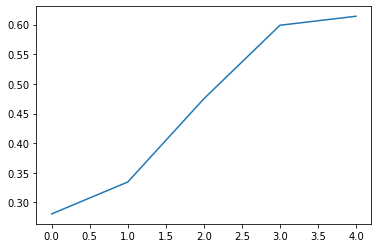

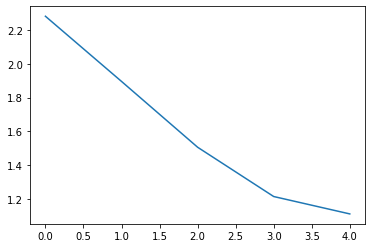

              precision    recall  f1-score   support

           0       0.47      0.73      0.57      6499
           1       0.80      0.96      0.87     18276
           2       0.00      0.00      0.00      2057
           3       0.90      0.03      0.06      3003
           4       0.92      1.00      0.96      1318
           5       0.85      0.23      0.36      4929
           6       0.00      0.00      0.00      1303
           7       0.38      0.77      0.51      3608
           8       1.00      0.01      0.02       928

    accuracy                           0.66     41921
   macro avg       0.59      0.41      0.37     41921
weighted avg       0.67      0.66      0.59     41921



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [77]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train acc', 'val_accuracy'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val_loss'], loc='upper left')
plt.show()


model.load_weights('/content/gdrive/My Drive/indiana/Pavia/my_model.h5')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


# Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
# ytest = np_utils.to_categorical(ytest)

import warnings
warnings.filterwarnings('always')

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)


classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [78]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        # target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn']
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
                        
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100



classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/gdrive/My Drive/indiana/Pavia/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))


def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



1311/1311 [==============================] - 5s 4ms/step - loss: 0.9323 - accuracy: 0.6564


In [0]:
t = sio.loadmat('/content/gdrive/My Drive/indiana/Pavia/PaviaU.mat')
f = sio.loadmat('/content/gdrive/My Drive/indiana/Pavia/PaviaU_gt.mat')
X = t['paviaU']
y = f['paviaU_gt']

height = y.shape[0]
width = y.shape[1]

PATCH_SIZE = windowSize
numComponents = K

X,pca = applyPCA(X, numComponents=numComponents)
X = padWithZeros(X, PATCH_SIZE//2)

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

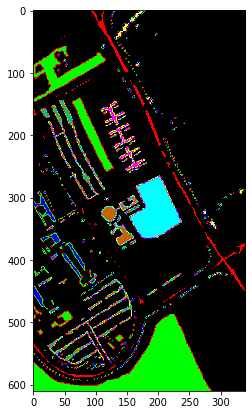

In [66]:
import spectral
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

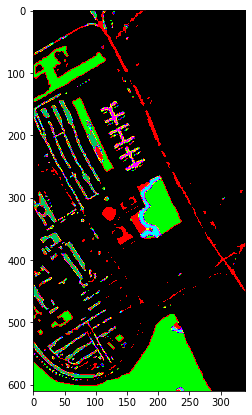

In [80]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
